## Advanced Lane Finding Project

The goals / steps of this project are the following:

1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.


In [30]:
import numpy as np
import cv2
import glob
import pickle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

## 0. Helper Functions

In [31]:
##  Define helper functions

# binary output use abs_sobel gradient thresh
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, abs_thresh=(0,255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1,ksize=sobel_kernel))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= abs_thresh[0]) & (scaled_sobel <= abs_thresh[1])] = 1

    # Return the result
    return binary_output
def rgb_thresh(img,rgb_threshold):
# R & G thresholds so that yellow lanes are detected well.
    R = img[:,:,0]
    G = img[:,:,1]
    B = img[:,:,2]
    binary_output = np.zeros_like(R)
    binary_output[(B > rgb_threshold[0]) & (B < rgb_threshold[1])]=1

    return binary_output
  
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output


# Define a function to return directon threshold of an image 
#for a given range and Sobel kernel 
def dir_threshold(img, sobel_kernel=3, dir_thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= dir_thresh[0]) & (absgraddir <= dir_thresh[1])] = 1

    # Return the binary image
    return binary_output


# Define a function that thresholds the S-channel of HLS
def hls_select(img,s_thresh,l_thresh):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    l_channel = hls[:,:,1]
    S_binary_output = np.zeros_like(s_channel)
    L_binary_output = np.zeros_like(l_channel)
    S_binary_output[(s_channel > s_thresh[0]) & (s_channel <= s_thresh[1])]=1
    L_binary_output[(l_channel > l_thresh[0]) & (l_channel <= l_thresh[1])] = 1
    
    return L_binary_output,S_binary_output

def luv_thresh(img,luv_threshold):
    l_channel = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)[:,:,0]
    u_channel = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)[:,:,1]
    v_channel = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)[:,:,2]
    
    L_binary_output = np.zeros_like(l_channel)
    L_binary_output[(l_channel >= luv_threshold[0]) & (l_channel <= luv_threshold[1])] = 1
    
    return L_binary_output


def lab_thresh(img,lab_threshold):
    l_channel = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)[:,:,0] 
    a_channel = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)[:,:,1] 
    b_channel = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)[:,:,2] 
    
    B_binary_output = np.zeros_like(b_channel)
    B_binary_output[(b_channel >= lab_threshold[0]) & (b_channel <= lab_threshold[1])] = 1
    
    return B_binary_output

# Calculate perspective transform matrix based on test image (straight lane)

def warp(img,offset=350):
    img_size = (img.shape[1], img.shape[0])
    # four corners of trapezoidal shape are chosen as src
    # dst is set by corners of 4 corners of a rectangle (distance (x) to original point is offset)

    src=np.float32(
        [[600,450],
         [680,450],
         [1080,720],
         [200,720]])

    dst = np.float32([[offset, 0], [img_size[0]-offset, 0], 
                                     [img_size[0]-offset, img_size[1]], 
                                     [offset, img_size[1]]])
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    InvM = cv2.getPerspectiveTransform(dst, src)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(img, M, img_size)

    # Return the resulting image and matrix
    return warped,M,InvM

## 1. Preparation-- camera calibration and  perspective transform

### 1.1 Camera Calibration

In [32]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = mpimg.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)
    
    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

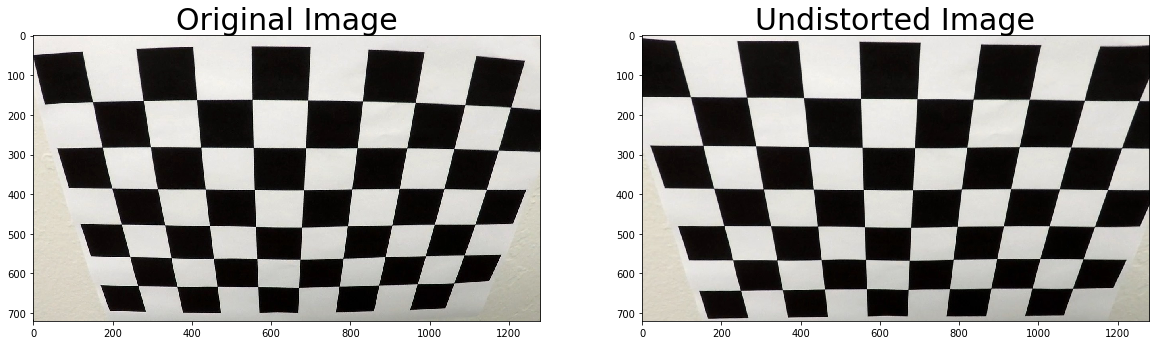

In [33]:
# Test undistortion on an image from test_images folder
img = mpimg.imread('camera_cal/calibration2.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

undist = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('output_images/test_undist.jpg',undist)

# Not a must, save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "calibration_results.p", "wb" ) )

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undist)
ax2.set_title('Undistorted Image', fontsize=30)

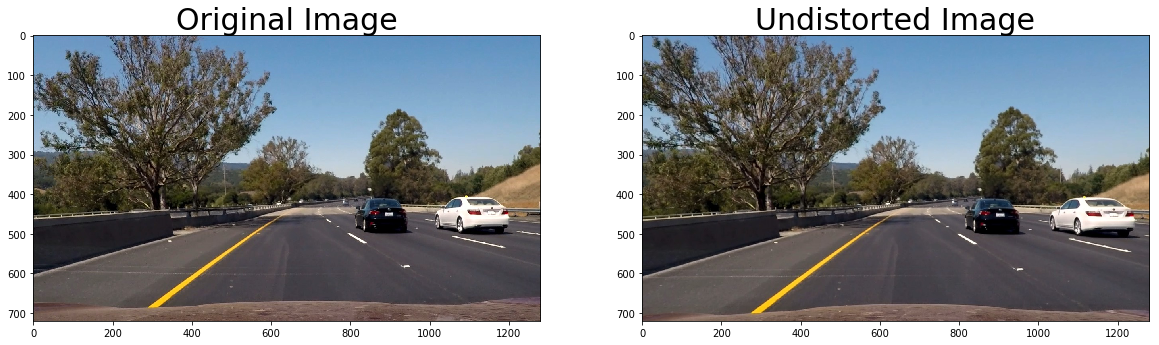

In [36]:
# Test undistortion on an image from test_images folder
img = mpimg.imread('test_images/test6.jpg')
img_size = (img.shape[1], img.shape[0])

undist = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('output_images/test_undist1.jpg',undist)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undist)
ax2.set_title('Undistorted Image', fontsize=30)

### 1.2  Perspective transform example

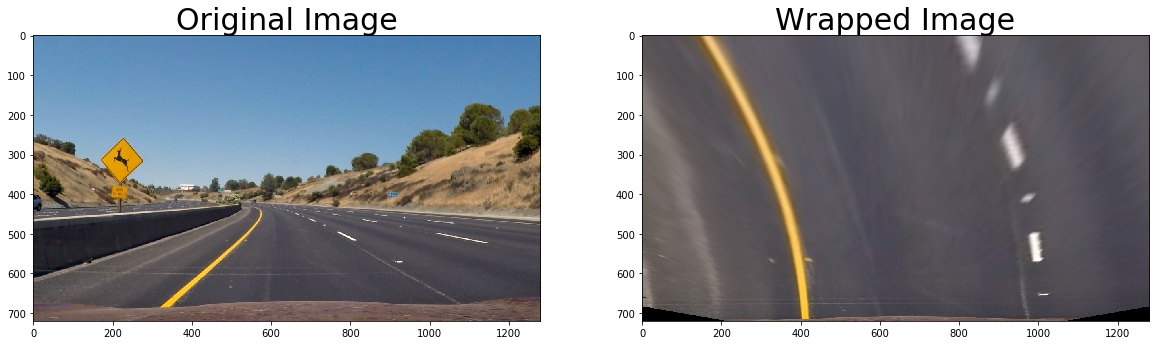

In [5]:
img = mpimg.imread('test_images/test2.jpg')
undist = cv2.undistort(img, mtx, dist, None, mtx)
warped,M,InvM = warp(undist,350)

# Visualize perspective transform
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(warped)
ax2.set_title('Wrapped Image', fontsize=30)


## 2. Lane Finding Pipe Line (image)

  2.1  Find raw lane without fit
        * Distortion correction to raw image.
        * Use color transforms, gradients, etc., to create a thresholded binary image.
        * Apply a perspective transform to rectify binary image ("birds-eye view").
  2.2 Polynomial fit  
  2.3 curature and offset calculation   
  2.4 warp back lane back to original image   


### 2.1  Find raw lane without fit

In [6]:
# Define original lane_finding function, the output is binary warped lanes 
def binary_warped_fun(img,ksize,mtx,dist):
    
    # 1.DistortionCorrection
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    gray = cv2.cvtColor(undist, cv2.COLOR_RGB2GRAY)

    # 2. Use gradients and color to create a thresholded binary image. 
    #gradx = abs_sobel_thresh(undist, orient='x', sobel_kernel=ksize, abs_thresh=(8,200))
    #grady = abs_sobel_thresh(undist, orient='y', sobel_kernel=ksize, abs_thresh=(5,100))
    #mag_binary = mag_thresh(undist, sobel_kernel=ksize, mag_thresh=(30, 100))
    dir_binary = dir_threshold(undist, sobel_kernel=ksize, dir_thresh=(np.pi/6, np.pi/2))
    #r_g_binary=rgb_thresh(undist,rgb_threshold=(200,200))
    #l_binary,s_binary = hls_select(undist, s_thresh = (50, 255),l_thresh = (160, 255))
    
    # new added threshold
    lab_binary=lab_thresh(undist,lab_threshold=(150,220))
    luv_binary=luv_thresh(undist,luv_threshold=(220,255))
    
    
    # combined threshold    
    combined = np.zeros_like(dir_binary)
    combined[((lab_binary==1)|(luv_binary==1))&(dir_binary == 1)] = 1
    #3. add mask for interest area
    mask = np.zeros_like(combined)
    height, width = gray.shape
    region_of_interest_vertices = np.array([[0,height], [0.5*width-100, 0.5*height+80], [0.5*width+100, 0.5*height+80],[width, height]], dtype=np.int32)
    cv2.fillPoly(mask, [region_of_interest_vertices], 1)
    
    thresholded = cv2.bitwise_and(combined, mask)
    return undist,thresholded


In [7]:
# Define original lane_finding function, the output is binary warped lanes 
def binary_warped_fun_nomask(img,ksize,mtx,dist):
    
    # 1.DistortionCorrection
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    gray = cv2.cvtColor(undist, cv2.COLOR_RGB2GRAY)

    # 2. Use gradients and color to create a thresholded binary image. 
    #gradx = abs_sobel_thresh(undist, orient='x', sobel_kernel=ksize, abs_thresh=(10,200))
    #grady = abs_sobel_thresh(undist, orient='y', sobel_kernel=ksize, abs_thresh=(5,100))
    #mag_binary = mag_thresh(undist, sobel_kernel=ksize, mag_thresh=(30, 100))
    dir_binary = dir_threshold(undist, sobel_kernel=ksize, dir_thresh=(np.pi/6, np.pi/2))
    #l_binary,s_binary = hls_select(undist, s_thresh = (50, 255),l_thresh = (225, 255))
    
    lab_binary=lab_thresh(undist,lab_threshold=(150,220))
    luv_binary=luv_thresh(undist,luv_threshold=(220,255))
    # combined threshold    
    combined = np.zeros_like(dir_binary)
    combined[((lab_binary==1)|(luv_binary==1))&(dir_binary == 1)] = 1


    thresholded = combined
    return undist,thresholded


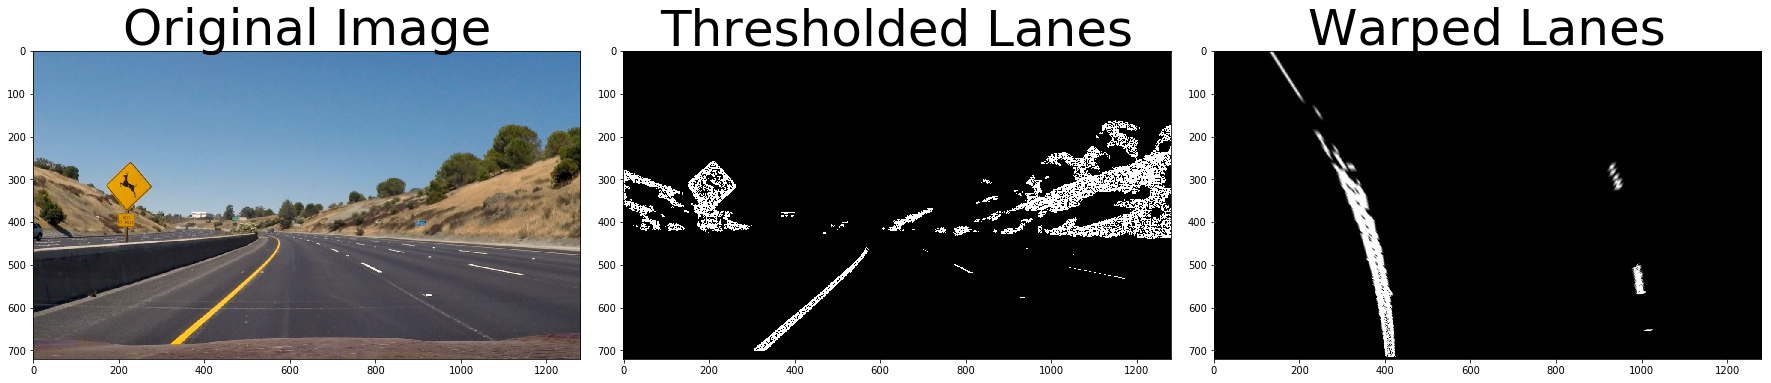

In [8]:
# Test lane finding function with one image
img = mpimg.imread('test_images/test2.jpg')

undist,thresholded=binary_warped_fun_nomask(img,3,mtx,dist)
binary_warped,M,InvM = warp(thresholded,350)

##Visualization
f, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(thresholded, cmap='gray')
ax2.set_title('Thresholded Lanes', fontsize=50)
ax3.imshow(binary_warped, cmap='gray')
ax3.set_title('Warped Lanes', fontsize=50)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


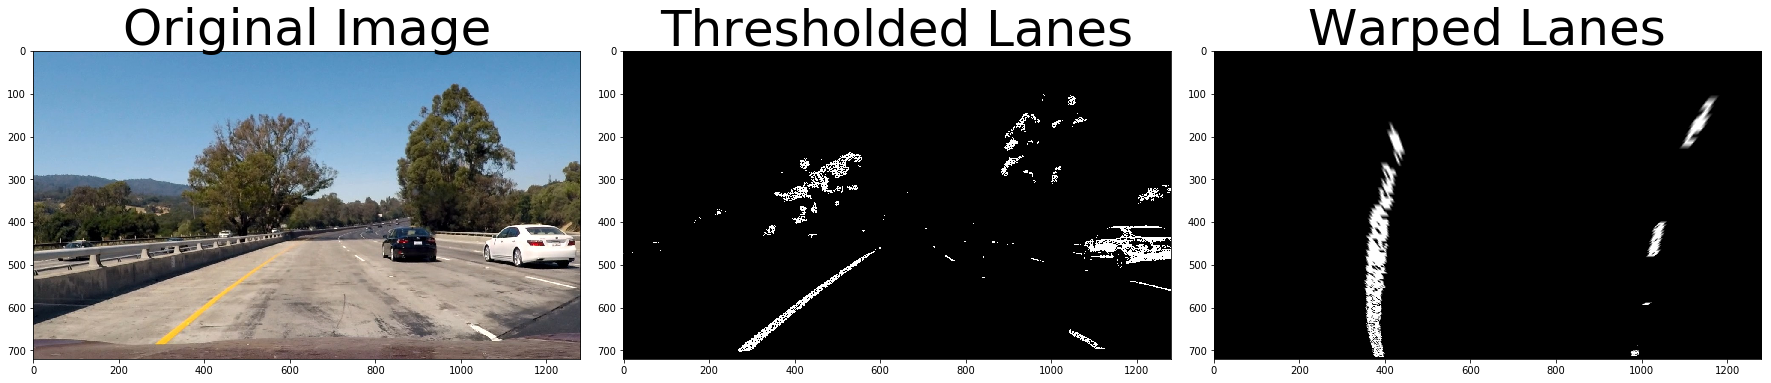

In [9]:
# Test lane finding function with one image
img = mpimg.imread('test_images/test1.jpg')
undist,thresholded=binary_warped_fun_nomask(img,3,mtx,dist)
binary_warped,M,InvM = warp(thresholded,350)

##Visualization
f, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(thresholded, cmap='gray')
ax2.set_title('Thresholded Lanes', fontsize=50)
ax3.imshow(binary_warped, cmap='gray')
ax3.set_title('Warped Lanes', fontsize=50)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

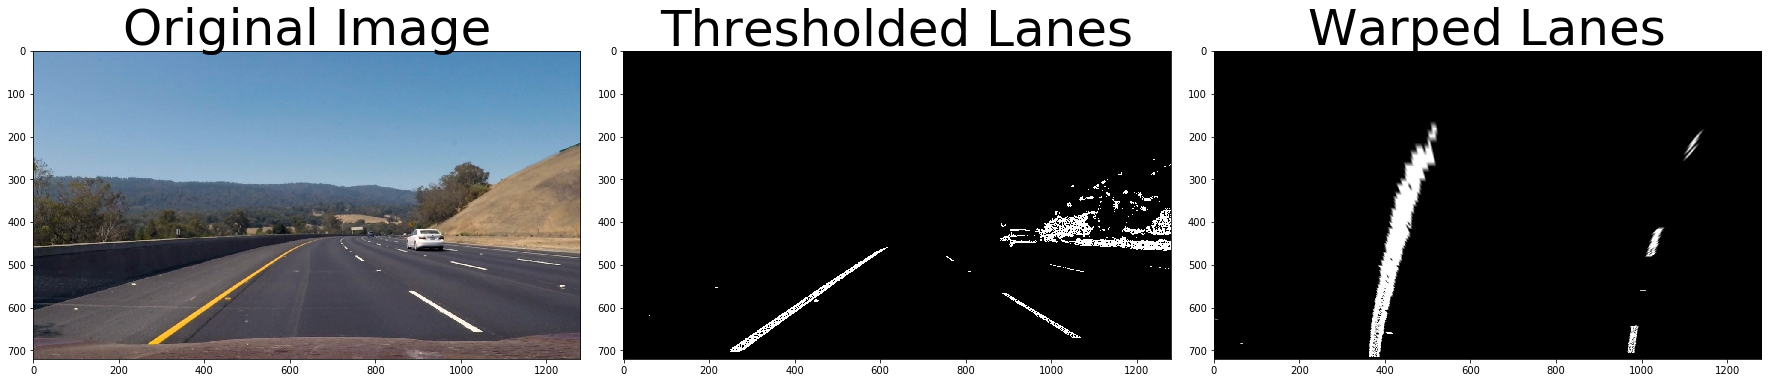

In [10]:
# Test lane finding function with one image
img = mpimg.imread('test_images/test3.jpg')
undist,thresholded=binary_warped_fun_nomask(img,3,mtx,dist)
binary_warped,M,InvM = warp(thresholded,350)

##Visualization
f, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(thresholded, cmap='gray')
ax2.set_title('Thresholded Lanes', fontsize=50)
ax3.imshow(binary_warped, cmap='gray')
ax3.set_title('Warped Lanes', fontsize=50)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

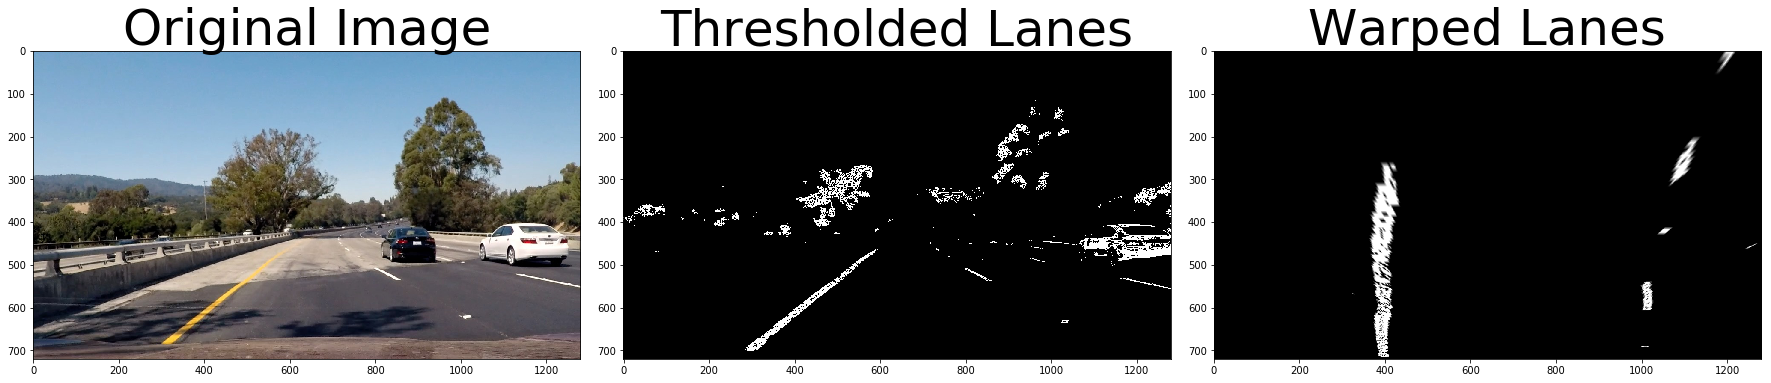

In [11]:
# Test lane finding function with one image
img = mpimg.imread('test_images/test4.jpg')
undist,thresholded=binary_warped_fun_nomask(img,3,mtx,dist)
binary_warped,M,InvM = warp(thresholded,350)

##Visualization
f, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(thresholded, cmap='gray')
ax2.set_title('Thresholded Lanes', fontsize=50)
ax3.imshow(binary_warped, cmap='gray')
ax3.set_title('Warped Lanes', fontsize=50)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

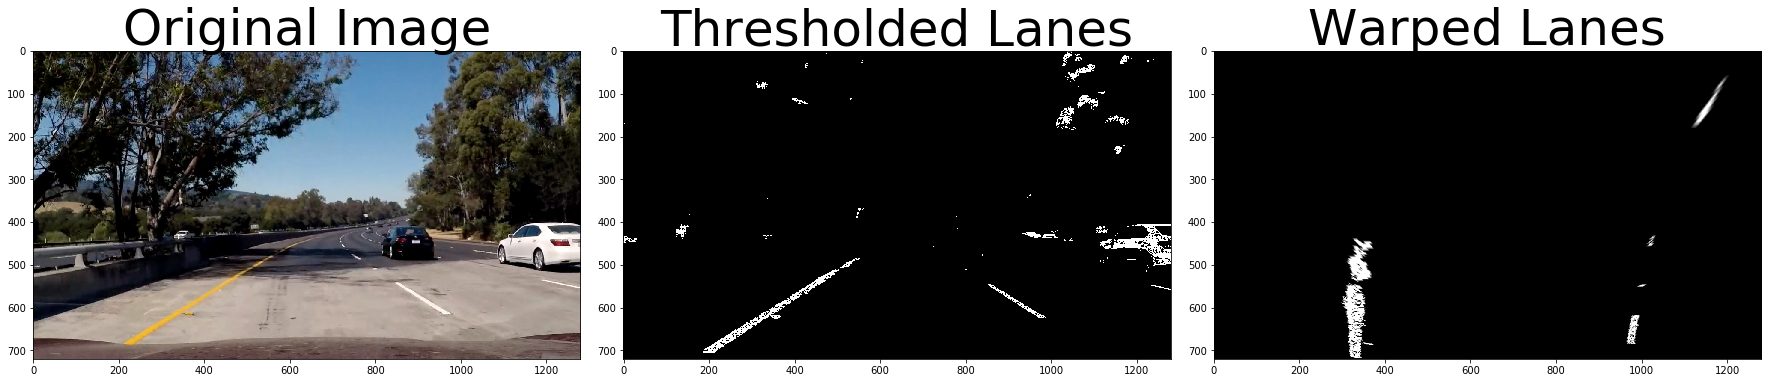

In [12]:
# Test lane finding function with one image
img = mpimg.imread('test_images/test5.jpg')
undist,thresholded=binary_warped_fun_nomask(img,3,mtx,dist)
binary_warped,M,InvM = warp(thresholded,350)


##Visualization
f, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(thresholded, cmap='gray')
ax2.set_title('Thresholded Lanes', fontsize=50)
ax3.imshow(binary_warped, cmap='gray')
ax3.set_title('Warped Lanes', fontsize=50)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### 2.2 Polynomial fit  

In [13]:
##Implement Sliding Windows and Fit a Polynomial the output is polynomial fite

def polynomial_fit_1st(binary_warped,nwindows=9,margin=100,minpix=50,visual=True,ym_per_pix = 30/720,xm_per_pix = 3.7/700):
    
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    #plt.plot(histogram)

    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint


    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    ##Visualization
    # Generate x and y values for plotting
    if visual==True:
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        plt.imshow(out_img)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)

    return left_fit,right_fit,left_fit_cr,right_fit_cr


### 2.3 Curature and offset calculation

In [14]:
# Calculate radius in meters
def curature_calc(left_fit_cr,right_fit_cr,ym_per_pix = 30/720,xm_per_pix = 3.7/700):
    #y_eval = image.shape[0]
    y_eval = 720
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

    # Now our radius of curvature is in meters
    return left_curverad, right_curverad
    # Example values: 632.1 m    626.2 m

def offset_calc(left_fit_cr,right_fit_cr,ym_per_pix = 30/720,xm_per_pix = 3.7/700):
    # take biggest y value as evaulation piont
    #y_eval = img.shape[0]*ym_per_pix
    y_eval = 720*ym_per_pix
    left_x = left_fit_cr[0]*y_eval**2+left_fit_cr[1]*y_eval+left_fit_cr[2]
    right_x = right_fit_cr[0]*y_eval**2+right_fit_cr[1]*y_eval+right_fit_cr[2]
    lane_mid= left_x+(right_x-left_x)/2
    
    #pic_mid = img.shape[1]/2*xm_per_pix
    pic_mid = 1280/2*xm_per_pix
    offset = lane_mid - pic_mid
    
    return offset


## 3. Lane Finding Pipeline (vedio)
 3.1 class defination and instances creation   
 3.2 lane finding   
 3.3 sanity check    
 3.4 smooth  

### 3.1 class defination and instances creation
 You can create an instance of the Line() class for the left and right lane lines 
to keep track of recent detections and to perform sanity checks.


In [15]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None



### 3.2 Lane finding in vedio

In [16]:
# Assume you now have a new warped binary image 
# from the next frame of video (also called "binary_warped")
# It's now much easier to find line pixels!
def polynomial_fit(binary_warped,left_fit,right_fit,ym_per_pix = 30/720,xm_per_pix = 3.7/700):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    return left_fit,right_fit,left_fit_cr,right_fit_cr


### Sanity Check

Before moving on, you should check that the detection makes sense. To confirm that your detected lane lines are real, you might consider:

   * Checking that they have similar curvature
   * Checking that they are separated by approximately the right distance horizontally
   * Checking that they are roughly parallel


In [17]:
# sanity check 
def check(left_curverad,right_curverad,right_fit_cr,left_fit_cr,curverad_thresh=(500,1500),curverad_diff_thresh=100,distance_thresh=1):
    # curverad reasonable
    curverad_diff=np.absolute(left_curverad-right_curverad)
    pass_curature=(curverad_thresh[1]>left_curverad>curverad_thresh[0])and(curverad_thresh[1]>right_curverad>curverad_thresh[0])and(curverad_diff<curverad_diff_thresh)
    
    # right distance horizontally
    distance_1= np.absolute((right_fit_cr[0]-left_fit_cr[0])/2.)
    pass_distance=(3.7-distance_thresh)<distance_1<(3.7+distance_thresh)
    
    # roughly parallel
    distance_2= np.absolute((right_fit_cr[-1]-left_fit_cr[-1])/2.)
    pass_parallel=np.absolute(distance_2-distance_1)<distance_thresh
    
    check=pass_distance and pass_curature and pass_parallel
    return check


### SMOOTH

Even when everything is working, your line detections will jump around from frame to frame a bit and it can be preferable to smooth over the last n frames of video to obtain a cleaner result. Each time you get a new high-confidence measurement, you can append it to the list of recent measurements and then take an average over n past measurements to obtain the lane position you want to draw onto the image.

In [18]:

# smooth function, use last total_numbers of detected lanes to output average lane

def smooth(fit_ok,new_fit,old_lanes,ploty,total_number):
    global new_lane
    # if no new acceptable lane found in last frame, reset stored lanes
    if fit_ok==False:
        if old_lanes==[]:
            new_lane = new_fit[0]*ploty**2 + new_fit[1]*ploty + new_fit[2]
            return old_lanes,new_lane
        else:
            return old_lanes, old_lanes[-1]
    else:
        # calcualte new lane
        new_lane = new_fit[0]*ploty**2 + new_fit[1]*ploty + new_fit[2]
        if len(old_lanes) < total_number:
        # create array to store new lane 
        #if not enough frames storeed
            old_lanes.append(new_lane)
            return old_lanes, new_lane
        else:
            # average over the last num_frames frames
            old_lanes[0:total_number-1] = old_lanes[1:]
            old_lanes[total_number-1] = new_lane
            new_lane = np.zeros_like(new_lane)
            for i in range(total_number):
                new_lane += old_lanes[i]
            new_lane /= total_number
            return old_lanes, new_lane

    return old_lanes,new_lane


### Plot function

In [19]:
def plot_fun(warped,left_fitx,right_fitx,ploty,image,curverad,offest,InvM,undist):
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (InvM)
    newwarp = cv2.warpPerspective(color_warp, InvM, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
        
    # Add text to output 
    font = cv2.FONT_HERSHEY_SIMPLEX
    text = "Radius of Cure is: {} m".format(int(curverad))
    cv2.putText(result,text,(100,50), font, 1,(255,255,255),2)
    if offset < 0:
        text = "Vehicle is {:.2f} m right of center".format(-offset)
    else:
        text = "Vehicle is {:.2f} m left of center".format(offset)
    cv2.putText(result,text,(100,100), font, 1,(255,255,255),2)
    
    return result 

In [20]:
# Main logic
def process_image(image):
    # define global variables
    global left_fit_ok
    global right_fit_ok
    global old_left_lanes
    global old_right_lanes
    global offset
    global left_fit
    global right_fit
    
    # set parameters
    ksize=3
    ym_per_pix = 30/720
    xm_per_pix = 3.7/700
    nwindows=9
    margin=100
    minpix=50
    visual=False
    curverad_thresh=(500,1500)
    curverad_diff_thresh=100
    distance_thresh=1
    total_number=10

    
    # Read in camera calibration results
    dist_pickle = pickle.load( open( "calibration_results.p", "rb" ) )
    mtx = dist_pickle["mtx"]
    dist = dist_pickle["dist"]
    
    # Lane finding
    undist,combined=binary_warped_fun(image,ksize,mtx,dist)
    
    # Apply perspective transform
    binary_warped,M,InvM = warp(combined,offset=350) 
    
    # Implement sliding windows and fit a polynomial
    if left_fit_ok==False|right_fit_ok==False:
        left_fit,right_fit,left_fit_cr,right_fit_cr=polynomial_fit_1st(binary_warped,nwindows,margin,minpix,visual,ym_per_pix,xm_per_pix)
    else:
        left_fit,right_fit,left_fit_cr,right_fit_cr=polynomial_fit(binary_warped,left_fit,right_fit,ym_per_pix,xm_per_pix)
    
    # curve radius and distance to center calculation for new detected lane
    left_curverad, right_curverad=curature_calc(left_fit_cr,right_fit_cr,ym_per_pix,xm_per_pix)
    offset=offset_calc(left_fit_cr,right_fit_cr,ym_per_pix,xm_per_pix)
   
    # sanity check
    
    check_pass=check(left_curverad,right_curverad,right_fit_cr,left_fit_cr,curverad_thresh,curverad_diff_thresh,distance_thresh)
    if check_pass==False:
        left_fit_ok=False
        right_fit_ok=False
    else:
        left_fit_ok=True
        right_fit_ok=True
    
    # smooth lanes with total number of frames
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    old_left_lanes,left_fitx=smooth(left_fit_ok,left_fit,old_left_lanes,ploty,total_number)
    old_right_lanes,right_fitx=smooth(right_fit_ok,right_fit,old_right_lanes,ploty,total_number)

    # curve radius and distance to center calculation for filtered lane
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    
    left_curverad, right_curverad=curature_calc(left_fit_cr,right_fit_cr,ym_per_pix,xm_per_pix)
    offset=offset_calc(left_fit_cr,right_fit_cr,ym_per_pix,xm_per_pix)
    # plot result
    result = plot_fun(binary_warped,left_fitx,right_fitx,ploty,image,left_curverad,offset,InvM,undist)
    
    return result
    

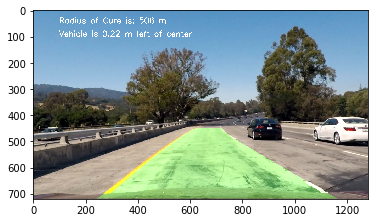

In [21]:
# initialize
left_fit_ok=False
right_fit_ok=False
old_left_lanes=[]
old_right_lanes=[]

img = mpimg.imread('test_images/test1.jpg')
result=process_image(img)

cv2.imwrite('output_images/result_example.jpg',result)
plt.imshow(result)

In [22]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

# initialize
left_fit_ok=False
right_fit_ok=False
old_left_lanes=[]
old_right_lanes=[]

white_output = 'result.mp4'
clip1 = VideoFileClip("project_video.mp4")

white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)


[MoviePy] >>>> Building video result.mp4
[MoviePy] Writing video result.mp4


100%|█████████▉| 1260/1261 [05:19<00:00,  3.76it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: result.mp4 

CPU times: user 6min 48s, sys: 1min 19s, total: 8min 7s
Wall time: 5min 21s
